In [0]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.30 # simple validation using train_test_split

#CROSS-VALIDATION 交叉验证
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

import os

The datasets contains transactions made by credit card cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.


In [0]:
data_df = pd.read_csv('/home/CreditCardFraud/data/creditcard.csv')

In [0]:
data_df.shape

(284807, 31)

In [0]:
data_df.head() # class中0代表正常交易，1代表fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
data_df.describe() #看mean和median是否相近，如果是则是正态分布

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [0]:
#check missing data 遗漏数据怎么找, 结果都是0，说明没有missing data
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum() /data_df.isnull().count() * 100).sort_values(ascending = False)
pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data unbalance

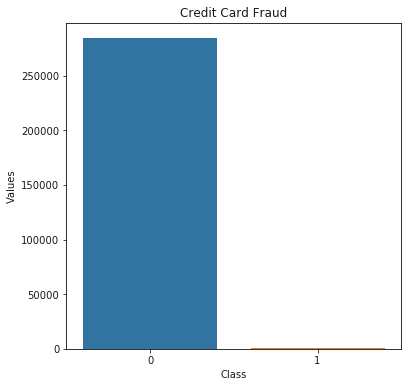

In [0]:
# 值为1 的为fraud，整个图像非常不均衡
temp = data_df['Class'].value_counts()
df = pd.DataFrame({'Class' : temp.index, 'Values' : temp.values})
plt.figure(figsize = (6, 6))
plt.title('Credit Card Fraud')
sns.set_color_codes('pastel')
sns.barplot(x = 'Class', y = 'Values', data = df)
locs, labels = plt.xticks()
plt.show()

NOTE: Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

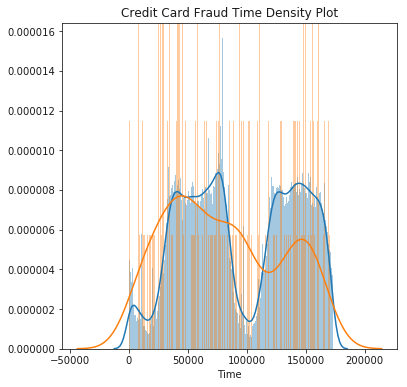

In [0]:
# 交易在时间上的分布，0是正常，1 是fraud，此图为两个分布的叠加。loc表示位置location

class_0 = data_df.loc[data_df['Class'] == 0]['Time']
class_1 = data_df.loc[data_df['Class'] == 1]['Time']
plt.figure(figsize = (6, 6))
plt.title('Credit Card Fraud Time Density Plot')
sns.set_color_codes('pastel')
sns.distplot(class_0, kde = True, bins = 480)
sns.distplot(class_1, kde = True, bins = 480)
plt.show()

NOTE: Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

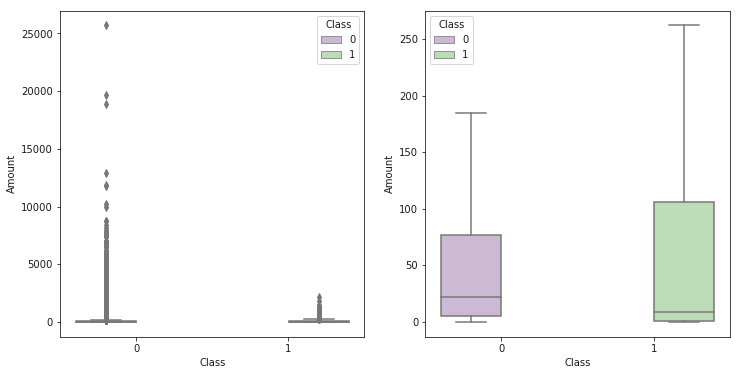

In [0]:
# 做一个箱型图，看一下不同的amount在class为0或1上的分布

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 6))  # subplots为子图, 此处画了两个子图，大小为12x6
s = sns.boxplot(ax = ax1, x = 'Class', y = 'Amount', hue = 'Class', data = data_df, palette = 'PRGn', showfliers = True)  # hue表示按照class性质分为两类，showfliers表示展示outlier
s = sns.boxplot(ax = ax2, x = 'Class', y = 'Amount', hue = 'Class', data = data_df, palette = 'PRGn', showfliers = False)
plt.show()


Features density plot

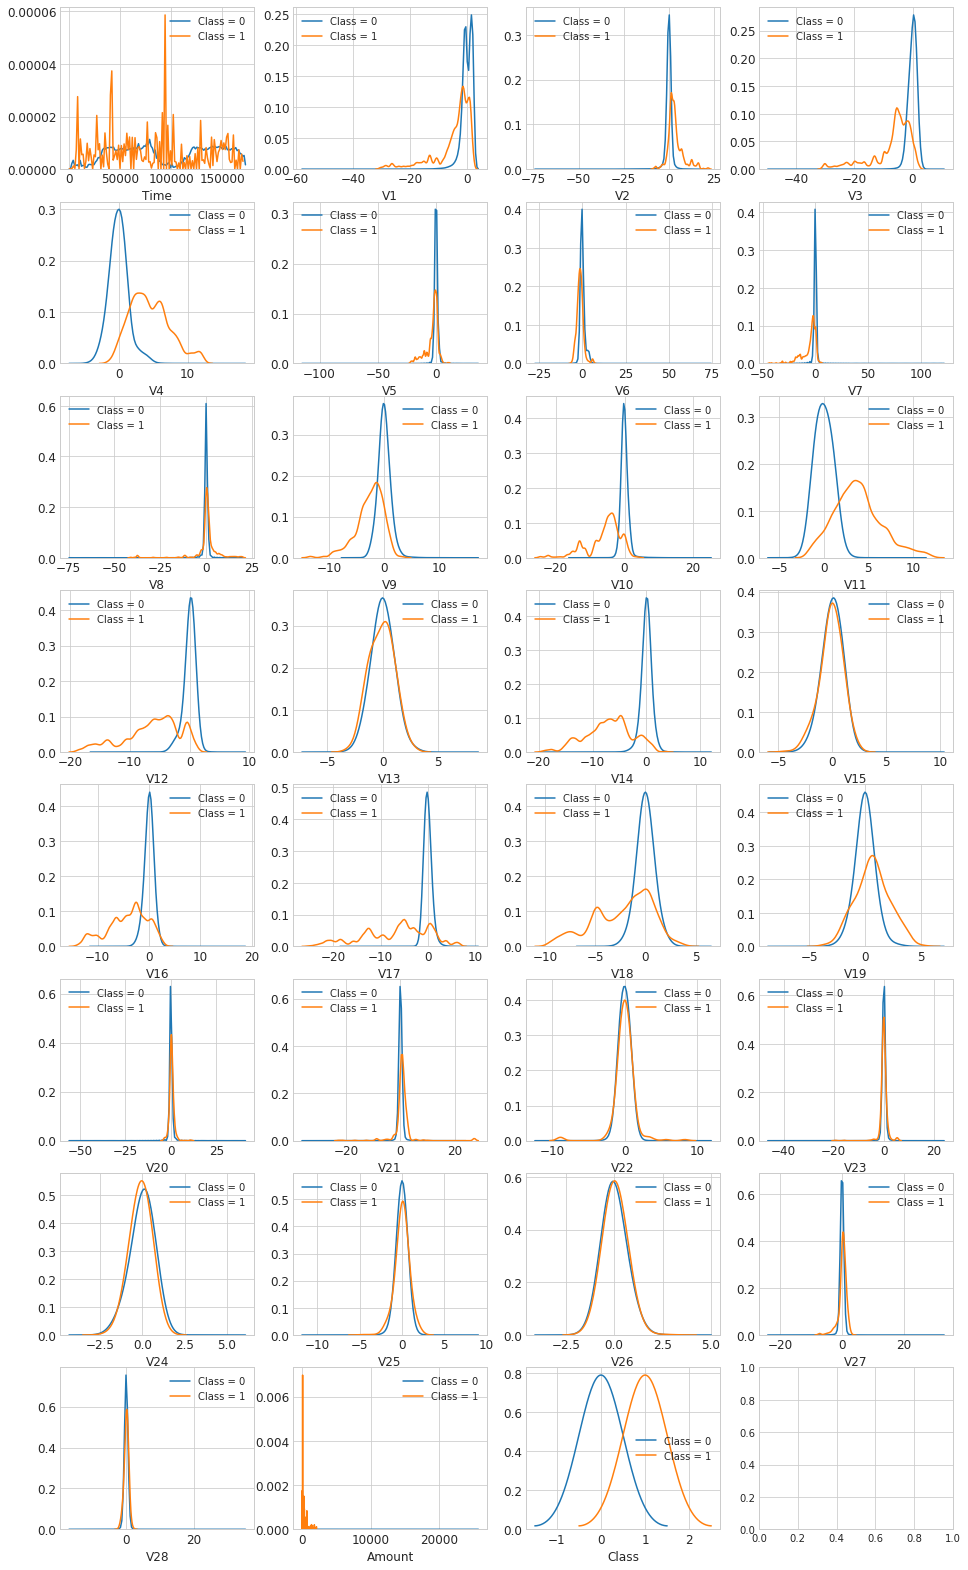

In [0]:
### 看数据集中每个column/feature对class=0/1的影响程度，两个曲线重合的越少越好

var = data_df.columns.values
i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8, 4, figsize = (16, 28)) # 8行4列
for feature in var:
    i += 1
    plt.subplot(8, 4, i)
    sns.kdeplot(t0[feature], bw = 0.5, label = 'Class = 0')  # bw为width, kde为密度分布图
    sns.kdeplot(t1[feature], bw = 0.5, label = 'Class = 1')
    plt.xlabel(feature, fontsize = 12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.

In [0]:
# Define predictors and target values
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [0]:
# Split data in train and validation set  分割traing和testsset
train_df, val_df = train_test_split(data_df, test_size = 0.3, random_state = 1000, shuffle = True)

In [0]:
train_df.shape # 训练数集

(199364, 31)

In [0]:
val_df.shape # 测试数集

(85443, 31)

In [0]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [0]:
# The parameters list for Logistic Regression
c_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
for c_param in c_param_range:
    print('=========================')
    print('C parameter: ', c_param)
    print('=========================')
    print('')
    lr = LogisticRegression(C = c_param, penalty = 'l1')   ##### lr表示logistic regression
    lr.fit(train_df[predictors], train_df[target].values)
    preds = lr.predict(val_df[predictors])
    print('Logistic Regression - AUC: ', roc_auc_score(val_df[target].values, preds))
    

C parameter:  0.001

Logistic Regression - AUC:  0.6149732973
C parameter:  0.01

Logistic Regression - AUC:  0.743350705233
C parameter:  0.1

Logistic Regression - AUC:  0.782812664877
C parameter:  1

Logistic Regression - AUC:  0.789391612245
C parameter:  10

Logistic Regression - AUC:  0.792681085929
C parameter:  100

Logistic Regression - AUC:  0.792681085929


In [0]:
#      分别用 naive bayes(Gaussian, Bernoulli), Random Forest, XGBoost, LightGBM, KFold, Cross validation。寻找最佳model。

In [0]:
# Naive Bayse which asumming the numerical feature with Bernoulli distribution
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

bnb = BernoulliNB()
bnb.fit(train_df[predictors], train_df[target].values)
preds = bnb.predict(val_df[predictors])
print('Bernoulli Naive Bayes - AUC: ', roc_auc_score(val_df[target].values, preds))


Bernoulli Naive Bayes - AUC:  0.802508470999


In [0]:
# Naive Bayse which asumming the numerical feature with Gaussian distribution
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_df[predictors], train_df[target].values)
preds = gnb.predict(val_df[predictors])
print('Gaussian Naive Bayes - AUC: ', roc_auc_score(val_df[target].values, preds))

Gaussian Naive Bayes - AUC:  0.79007823217


In [0]:
# Random Forest 
# Pay attention now, we are using the GINI criterion in our Random Forest. 
# What doese it mean? (this is a homework for you.)

rf_clf = RandomForestClassifier(n_jobs = 4, #并行处理的数量
                               random_state = RANDOM_STATE, #每次随机采样的数量
                               criterion = RFC_METRIC,      # 度量值，用基尼系数做度量值
                               n_estimators = NUM_ESTIMATORS, #有多少棵分支小树
                               verbose = False)
rf_clf.fit(train_df[predictors], train_df[target].values)
preds = rf_clf.predict(val_df[predictors])
print('Random Forest - AUC: ', roc_auc_score(val_df[target].values, preds))

Random Forest - AUC:  0.86181865613


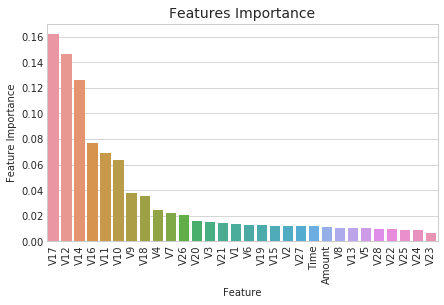

In [0]:
# 在上面random forest的基础上做一个实验
# Features Importance for Random Forest

tmp = pd.DataFrame({'Feature': predictors, 'Feature Importance' : rf_clf.feature_importances_})
tmp = tmp.sort_values(by = 'Feature Importance', ascending = False)
plt.figure(figsize = (7, 4))
plt.title('Features Importance', fontsize =  14)
s = sns.barplot(x = 'Feature', y = 'Feature Importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.show()

# 最重要的是V17

The most important features are V17, V12, V14, V10, V11, V16.

Confusion matrix
Let's show a confusion matrix for the results we obtained.

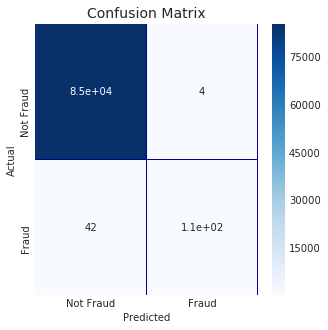

In [0]:
############  Confusion Matrix

cm = pd.crosstab(val_df[target].values, preds, rownames = ['Actual'], colnames = ['Predicted'])
fig, (ax1) = plt.subplots(ncols = 1, figsize = (5, 5))
sns.heatmap(cm,
            xticklabels = ['Not Fraud', 'Fraud'],  #x轴上标签
            yticklabels = ['Not Fraud', 'Fraud'],
            annot = True, ax = ax1,
            linewidth = 0.2, linecolor = 'Darkblue', cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 14)
plt.show()


What is Type I error and Type II error? (Homework for you)

In [0]:
# XGBoost
# Prepare the train and valida datasets as XGBoost specific data format
# 需要先把数据转换成XGB可以读的数据

dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

# XGBoost Parameters
params = {}
params['objective'] = 'binary:logistic'
#params['objective'] = 'multi:softmax'
#params['objective'] = 'reg:linear'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
#GridSearchCV

In [0]:
xgb_clf = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)

[0]	train-auc:0.883689	valid-auc:0.858383
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.93217	valid-auc:0.904332
[100]	train-auc:0.935717	valid-auc:0.913009
[150]	train-auc:0.977612	valid-auc:0.952417
[200]	train-auc:0.99187	valid-auc:0.971583
[250]	train-auc:0.995315	valid-auc:0.976283
[300]	train-auc:0.996968	valid-auc:0.976082
Stopping. Best iteration:
[268]	train-auc:0.995814	valid-auc:0.977115



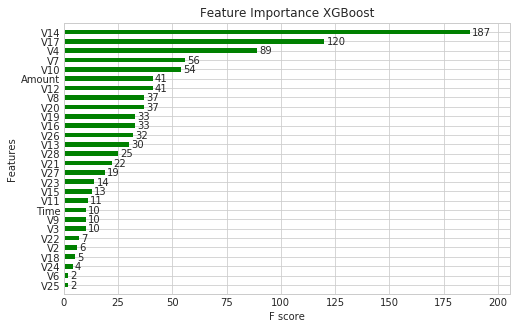

In [0]:
# XGBoost Feature Importance
fig, (ax) = plt.subplots(ncols = 1, figsize = (8, 5))
xgb.plot_importance(xgb_clf, height = 0.5, title = "Feature Importance XGBoost", ax = ax, color = "green")
plt.show()

In [0]:
# 用train数据集预测valid数据，看看准确率，注意dvalid是转换后适合XGBoost的数据

preds = xgb_clf.predict(dvalid)
print('XGBoost - AUC: ', roc_auc_score(val_df[target].values, preds))

XGBoost - AUC:  0.975575799631


In [0]:
#LightGBM Parameters

params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [0]:
# 把train_df转化成lgb可以用的数据集
# Prepare the train and valida datasets as LightGBM specific data format

dtrain = lgb.Dataset(train_df[predictors].values,
                    label = train_df[target].values,
                    feature_name = predictors)

dvalid = lgb.Dataset(val_df[predictors].values,
                    label = val_df[target].values,
                    feature_name = predictors)


In [0]:
evals_results = {}   # 评估evaluation
lgb_clf = lgb.train(params,
                   dtrain,
                   valid_sets = [dtrain, dvalid],
                   valid_names = ['train', 'valid'],
                   evals_result = evals_results,
                   num_boost_round = MAX_ROUNDS,
                    early_stopping_rounds = EARLY_STOP,
                    verbose_eval = VERBOSE_EVAL,
                    feval = None)

                    

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.996188	valid's auc: 0.965456
[100]	train's auc: 0.999529	valid's auc: 0.973762
Early stopping, best iteration is:
[80]	train's auc: 0.999175	valid's auc: 0.974263


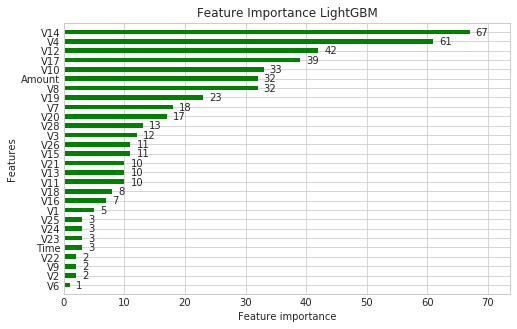

In [0]:
# LightGBM Feature Importance
fig, (ax) = plt.subplots(ncols = 1, figsize = (8, 5))
lgb.plot_importance(lgb_clf, height = 0.5, title = "Feature Importance LightGBM", ax = ax, color = "green")
plt.show()

In [0]:
# 用train数据集验证valid数据集，得到准确率

preds = lgb_clf.predict(val_df[predictors].values)    ##########括号内做预测用的是原始的数据集，与XGB不同，XGB用的是dvalid，是转换后的数据
print('LightGBM - AUC: ', roc_auc_score(val_df[target].values, preds))

LightGBM - AUC:  0.974263342402


Training and validation using cross-validation
Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

In [0]:
# KFold - Cross Validation

# len 表示数据集长度，n_folds切分的份数， random_state切分的种子数，shuffle表示是否要洗牌

kf = KFold(len(val_df[target].values), n_folds = NUMBER_KFOLDS, random_state = 100, shuffle = True)
for train_index, test_index in kf:
    train_x, valid_x = data_df.iloc[train_index], data_df.iloc[test_index]
    dtrain = lgb.Dataset(train_x[predictors].values, label = train_x[target].values,
                        feature_name = predictors)
    dvalid = lgb.Dataset(valid_x[predictors].values, label = valid_x[target].values,
                        feature_name = predictors)
    evals_results = {}
    lgb_clf = lgb.train(params,
                   dtrain,
                   valid_sets = [dtrain, dvalid],
                   valid_names = ['train', 'valid'],
                   evals_result = evals_results,
                   num_boost_round = MAX_ROUNDS,
                    early_stopping_rounds = EARLY_STOP,
                    verbose_eval = VERBOSE_EVAL,
                    feval = None)




Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.999587	valid's auc: 0.965493
Early stopping, best iteration is:
[16]	train's auc: 0.996884	valid's auc: 0.980167
Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.999216	valid's auc: 0.99144
[100]	train's auc: 0.999748	valid's auc: 0.996366
[150]	train's auc: 0.999833	valid's auc: 0.997348
[200]	train's auc: 0.999972	valid's auc: 0.997976
Early stopping, best iteration is:
[199]	train's auc: 0.999972	valid's auc: 0.998044
Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.998706	valid's auc: 0.991537
Early stopping, best iteration is:
[45]	train's auc: 0.998572	valid's auc: 0.992746
Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.998958	valid's auc: 0.990588
[100]	train's auc: 0.999751	valid's auc: 0.993723
[150]	train's auc: 0.999871	valid's auc: 0.994958
Early stopping, best iteration is:
[132]	train's auc: 

In [0]:
# SVM Classification  非常慢，要一个小时
svc = SVC(kernal = "rbf", c = 2.0, gamma = 3)  # kernal函数出现了用于升维
svc.fit(train_df[predictors], train_df[target].values)
preds = svc.predict(val_df[predictors])
print('SVM - AUC: ', roc_auc_score(val_df[target].values, preds))